In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [2]:
from DataPrep.load_data import load_data
import pyforest

In [3]:
df = pd.read_csv("data\createdDat\Data_Oskar\df_11052021.csv")
plug = pd.read_csv("data\createdDat\Data_Oskar\plugdf_11052021.csv")
hour = pd.read_csv("data\createdDat\Censorship_scheem\hour_two_data.csv")
hour["Start Date"] = pd.to_datetime(hour["Start Date"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
hour

,Unnamed: 0,Start Date,Original Charge Duration,Original Park Duration,Original Start,Charging Time (mins),Parking Time (mins),Energy (kWh),Fee (USD),Label
0,0,2011-10-10 14:00:00,157.100000,274.633333,2011-10-10 15:23:00,37.023567,64.722505,2.157608,0.000000,0
1,1,2011-10-10 16:00:00,157.100000,274.633333,2011-10-10 15:23:00,120.076433,209.910828,6.997647,0.000000,0
2,2,2011-10-10 18:00:00,157.100000,274.633333,2011-10-10 15:23:00,0.000000,0.000000,0.000000,0.000000,0
3,3,2011-10-10 18:00:00,123.966667,124.216667,2011-10-10 19:14:00,46.361518,46.455014,2.845726,0.000000,0
4,4,2011-10-10 20:00:00,123.966667,124.216667,2011-10-10 19:14:00,77.605149,77.761653,4.763498,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
348740,348740,2019-12-31 16:00:00,286.266667,304.683333,2019-12-31 17:27:00,33.030769,35.155769,1.802769,0.414231,7
348741,348741,2019-12-31 18:00:00,286.266667,304.683333,2019-12-31 17:27:00,120.111888,127.839161,6.555524,1.506294,7
348742,348742,2019-12-31 20:00:00,286.266667,304.683333,2019-12-31 17:27:00,120.111888,127.839161,6.555524,1.506294,7
348743,348743,2019-12-31 22:00:00,286.266667,304.683333,2019-12-31 17:27:00,13.012121,13.849242,0.710182,0.163182,7


In [4]:
plug[plug["Label"]==6].describe()

,Label,Plugs_raw,Number of NEMA 5-20R_raw,Plugs,Number of NEMA 5-20R
count,1448.0,1448.000000,1448.0,1448.000000,1448.0
mean,6.0,4.698895,0.0,4.696133,0.0
std,0.0,2.988658,0.0,2.984676,0.0
min,6.0,2.000000,0.0,2.000000,0.0
25%,6.0,2.000000,0.0,2.000000,0.0
50%,6.0,2.000000,0.0,2.000000,0.0
75%,6.0,8.000000,0.0,8.000000,0.0
max,6.0,10.000000,0.0,8.000000,0.0


In [26]:
def get_censored(df):
    plug = pd.read_csv("data\createdDat\Data_Oskar\plugdf_11052021.csv")

    df = df.drop(columns=["Unnamed: 0","Latitude","Longitude","CenterLat","CenterLon", "Plug Type"])
    df["Start Date"] = pd.to_datetime(df["Start Date"]) 
    test = pd.DataFrame(columns=list(df.columns))
    censors = []
    macs = []
    for label in range(8):
        maks = plug["Date"][plug["Label"]==label][plug[plug["Label"]==label]["Plugs"]==plug[plug["Label"]==label]["Plugs"].max()]
        intercept = maks[maks.index[0]]
        macs_until_intercept = df[(df["Label"]==label) & (df["Start Date"].dt.date<pd.to_datetime(intercept))]["Station Name"].unique()

        if label==5:
            macs_until_intercept = df["Station Name"][df["Label"]==label].unique()
 
        #Label 2 skal ikke censores kun 4 dage uden fuld kraft
        liste = df[df["Label"]==label]["Station Name"].isin(macs_until_intercept)

        censors.append(intercept)
        macs.append(macs_until_intercept)
        test = test.append(df[(df["Label"]==label) & (liste)]) 

    
    return test, censors, macs
    



In [27]:
test, censors, macs = get_censored(df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
censors

['2017-07-05',
 '2018-03-23',
 '2011-08-02',
 '2017-01-06',
 '2014-10-05',
 '2015-01-02',
 '2018-03-22',
 '2016-01-14']

In [26]:
'''
Bliver brugt i Censorship_to_2hour
'''
#test.to_csv("data\createdDat\Censorship_scheem\data_for_2hour_censored.csv")

In [9]:
def downsampling_to_days(df):
    labels = df["Label"].unique()
    dfClean2 = pd.DataFrame(columns = df.columns[1:])
    for label in labels:
        d = df[df["Label"] == label].resample("D", on="Start Date").agg({'Charging Time (mins)':'sum','Parking Time (mins)':'sum', 'Energy (kWh)':'sum', 'Fee (USD)':'sum'}).fillna('')
        d["Label"] = label
        
        dfClean2 = dfClean2.append(d)
    
    dfClean2 = dfClean2.reset_index()
    dfClean2 = dfClean2.rename(columns = {"index":"Start Date"})
    
    new_col_order = ['Start Date','Label','Charging Time (mins)','Parking Time (mins)', 'Energy (kWh)', 'Fee (USD)']
    dfClean3 = dfClean2[new_col_order]
    return dfClean3

In [30]:
df_down = downsampling_to_days(hour)
df_down = df_down.dropna(axis=1)
df_down=df_down.set_index("Start Date")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

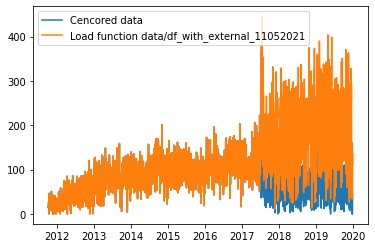

In [31]:
df = load_data()

plt.plot(df_down[df_down["Label"]==0]["Energy (kWh)"], label='Cencored data')
plt.plot(df_down[df_down["Label"]==0].index,df[df["Label"]==0]["Energy (kWh)"][-len(df_down[df_down["Label"]==0]["Energy (kWh)"]):], label="Load function data/df_with_external_11052021")
plt.legend()
plt.show()

In [32]:
for i in range(8):
    df_down.loc[lambda x: (x["Label"]==i) & (x.index>pd.to_datetime(censors[i])), "Censored"] = 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
df_down = df_down.fillna(0)

In [44]:
df_down.to_csv("data\createdDat\Censorship_scheem\Plugs_censord.csv")